# Refine Regions of Interest and Select EIS Raster Scans

In [14]:
import astropy.io.ascii
import astropy.units as u
import astropy.table
import astropy.time
import datetime
import matplotlib.pyplot as plt
import numpy as np
import sunpy.map
from sunpy.net import Fido, attrs as a
from sunpy.net.fido_factory import UnifiedResponse
from astropy.coordinates import SkyCoord
from sunpy.coordinates import Helioprojective, get_earth, get_horizons_coord,propagate_with_solar_surface
import eispac
import eispac.net
import eispac.core
import pandas
import pathlib
import fiasco

First, build the list of lines we want to fit. We'll do this by looking at the lines measured by Warren et al (2011) and then paring down the list from there.

In [15]:
intensities_warren = astropy.io.ascii.read('../data/tables/warren_2011_intensities.txt', format='mrt')
intensities_warren = intensities_warren[intensities_warren['Inst']=='EIS']
line_list = astropy.table.unique(intensities_warren[['ID']])

In [16]:
template_filenames = eispac.data.fit_template_filenames()
line_table_data = {
    'Element': [],
    'Z': [],
    'Ion': [],
    'Wavelength': [],
    'Template': [],
}
for line in line_list['ID']:
    el,ion,wave = line.lower().split()
    Z,ion = fiasco.util.parse_ion_name((el,ion))
    tname = f'{f"{el}_" if len(el)==1 else el}_{ion:02d}_{"_".join(wave.split("."))}'
    tname_files = [f.name for f in template_filenames if tname in f.name]
    line_table_data['Ion'] += len(tname_files)*[ion]
    line_table_data['Wavelength'] += len(tname_files)*[float(wave)]
    line_table_data['Element'] += len(tname_files)*[el.capitalize()]
    line_table_data['Z'] += len(tname_files)*[Z]
    line_table_data['Template'] += tname_files
selected_line_table = astropy.table.QTable(line_table_data)
selected_line_table['Wavelength'] = selected_line_table['Wavelength'] * u.AA
selected_line_table['Number Gaussians'] = list(map(lambda x: int(x.split('.')[1][:-1]), selected_line_table['Template']))
selected_line_table = selected_line_table[np.argsort(selected_line_table['Wavelength'])]
selected_line_table['Included lines'] = [eispac.read_template(eispac.data.get_fit_template_filepath(tf)).template['line_ids']
                                         for tf in selected_line_table['Template']] 

In [4]:
lines_are_duplicate = []
for row_outer in selected_line_table:
    duplicates = len(row_outer['Included lines'])*[False]
    for i,line in enumerate(row_outer['Included lines']):
        for row_inner in selected_line_table:
            if row_inner['Number Gaussians'] > row_outer['Number Gaussians'] and line in row_inner['Included lines']:
                duplicates[i] = True
                break
    lines_are_duplicate.append(all(duplicates))
#selected_line_table['Lines are duplicate'] = lines_are_duplicate
selected_line_table = selected_line_table[~np.array(lines_are_duplicate)]
# Make the list of lines a string
selected_line_table['Included lines'] = list(map(', '.join, selected_line_table['Included lines']))
# Manually dropping rows I know we don't want to include
selected_line_table.remove_rows([7,8,9])
selected_line_table.sort(keys=['Z','Ion','Wavelength'])

Note that we may only get a subset of *all* of the lines indicated in this table as each raster does not include all possible lines. 

In [5]:
selected_line_table

Element,Z,Ion,Wavelength,Template,Number Gaussians,Included lines
,,,Angstrom,,,
str2,int64,int64,float64,str28,int64,str89
Si,14,7,275.368,si_07_275_368.3c.template.h5,3,"Si VII 275.368, unknown I 275.553, Si VII 275.665"
Si,14,10,258.375,si_10_258_375.1c.template.h5,1,Si X 258.375
S,16,10,264.233,s__10_264_233.1c.template.h5,1,S X 264.233
S,16,13,256.686,s__13_256_686.1c.template.h5,1,S XIII 256.686
Ca,20,14,193.874,ca_14_193_874.6c.template.h5,6,"Fe X 193.715, Ca XIV 193.874, Ni XVI 194.046, Ar XI 194.104, Mn X 194.327, Ar XIV 194.396"
Ca,20,15,200.972,ca_15_200_972.2c.template.h5,2,"Ca XV 200.972, Fe XIII 201.121"
Ca,20,16,208.604,ca_16_208_604.2c.template.h5,2,"Ca XVI 208.604, Fe XIII 208.679"
Ca,20,17,192.858,ca_17_192_858.1c.template.h5,1,Ca XVII 192.858


Next, we're going to take a look at a few ARs that were observed repeatedly over multiple rotations. this is a dataset produced by Emily Mason. This cleans up the table a bit and adds more context to these ARs.

In [6]:
mason_ars = astropy.table.QTable.from_pandas(pandas.read_excel('../data/tables/ars_and_times_emason.xlsx'))
# Time
mason_ars['Date start'] = astropy.time.Time(mason_ars['Date1'])
mason_ars['Date end'] = astropy.time.Time(mason_ars['Date2'])
mason_ars['Date mid'] = mason_ars['Date start'] + (mason_ars['Date end'] - mason_ars['Date start'])/2
# Coordinates
blc = []
trc = []
for row_m,row in zip(mason_ars.mask, mason_ars):
    if row_m['bottom_left_x']:
        blc_Tx = row['X'] - row['W'] / 2
        blc_Ty = row['Y'] - row['H'] / 2
        trc_Tx = row['X'] + row['W'] / 2
        trc_Ty = row['Y'] + row['H'] / 2
    else:
        blc_Tx = row['bottom_left_x']
        blc_Ty = row['bottom_left_y']
        trc_Tx = row['top_right_x']
        trc_Ty = row['top_right_y']
    frame = Helioprojective(observer=get_horizons_coord('SDO', time=row['Date mid']), obstime=row['Date mid'])
    blc.append(SkyCoord(Tx=blc_Tx*u.arcsec, Ty=blc_Ty*u.arcsec, frame=frame))
    trc.append(SkyCoord(Tx=trc_Tx*u.arcsec, Ty=trc_Ty*u.arcsec, frame=frame))
mason_ars['bottom left'] = blc
mason_ars['top right'] = trc
# Clean up
mason_ars.rename_column('Unnamed: 12', 'Comment')
mason_ars.remove_columns([
    'Date1',
    'Date2',
    'Unnamed: 11',
    'bottom_left_x',
    'top_right_x',
    'bottom_left_y',
    'top_right_y',
    'X', 
    'Y', 
    'W',
    'H',
])

# Adding an ID that designates which ARs are the same from one rotation to the next
mason_ars['Region ID'] = 0
for i,row in enumerate(mason_ars):
    if i > 0:
        time_delta = row['Date mid'] - mason_ars[i-1]['Date mid']
        if time_delta < (30 * u.day):
            row['Region ID'] = mason_ars[i-1]['Region ID']
        else:
            row['Region ID'] = mason_ars[i-1]['Region ID'] + 1

INFO: Obtained JPL HORIZONS location for Solar Dynamics Observatory (spac [sunpy.coordinates.ephemeris]
INFO: Obtained JPL HORIZONS location for Solar Dynamics Observatory (spac [sunpy.coordinates.ephemeris]
INFO: Obtained JPL HORIZONS location for Solar Dynamics Observatory (spac [sunpy.coordinates.ephemeris]
INFO: Obtained JPL HORIZONS location for Solar Dynamics Observatory (spac [sunpy.coordinates.ephemeris]
INFO: Obtained JPL HORIZONS location for Solar Dynamics Observatory (spac [sunpy.coordinates.ephemeris]
INFO: Obtained JPL HORIZONS location for Solar Dynamics Observatory (spac [sunpy.coordinates.ephemeris]
INFO: Obtained JPL HORIZONS location for Solar Dynamics Observatory (spac [sunpy.coordinates.ephemeris]
INFO: Obtained JPL HORIZONS location for Solar Dynamics Observatory (spac [sunpy.coordinates.ephemeris]
INFO: Obtained JPL HORIZONS location for Solar Dynamics Observatory (spac [sunpy.coordinates.ephemeris]
INFO: Obtained JPL HORIZONS location for Solar Dynamics Observat

Next, I'm going to pare this table down to one region.

In [7]:
mason_ars = mason_ars[mason_ars['Region ID']==1]

And I'm going to manually adjust a few of the dates to avoid some flares and such that the intervals are roughly centered on the EIS rasters that we care about.

In [8]:
mason_ars[0]['Date start'] = astropy.time.Time('2014-01-08 06:00:00')
mason_ars[0]['Comment'] = "Adjusted start time to avoid flare on 2014-01-07 18:00:00"
mason_ars[1]['Date start'] = astropy.time.Time('2014-02-03 05:00:00')
mason_ars[1]['Comment'] = "Adjusted start time to center interval on EIS raster scan"
mason_ars[2]['Date start'] = astropy.time.Time('2014-03-01 18:00:00')
mason_ars[2]['Comment'] = "Adjusted start time to avoid eclipse on 2014-03-02 06:00:00"
mason_ars['Date end'] = mason_ars['Date start'] + 12*u.h
mason_ars['Date mid'] = mason_ars['Date start'] + (mason_ars['Date end'] - mason_ars['Date start'])/2

In [9]:
mason_ars

NOAA AR,Comment,Date start,Date end,Date mid,bottom left,top right,Region ID
int64,str80,Time,Time,Time,object,object,int64
11944,Adjusted start time to avoid flare on 2014-01-07 18:00:00,2014-01-08T06:00:00.000,2014-01-08T18:00:00.000,2014-01-08T12:00:00.000,"<SkyCoord (Helioprojective: obstime=2014-01-07T21:00:00.000, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2014-01-07T21:00:00.000, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, AU)\n (-0.00922921, -3.77897502, 0.98316623)>): (Tx, Ty) in arcsec\n (-300., -240.)>","<SkyCoord (Helioprojective: obstime=2014-01-07T21:00:00.000, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2014-01-07T21:00:00.000, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, AU)\n (-0.00922921, -3.77897502, 0.98316623)>): (Tx, Ty) in arcsec\n (125., 10.)>",1
11967,Adjusted start time to center interval on EIS raster scan,2014-02-03T05:00:00.000,2014-02-03T17:00:00.000,2014-02-03T11:00:00.000,"<SkyCoord (Helioprojective: obstime=2014-02-03T06:00:00.000, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2014-02-03T06:00:00.000, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, AU)\n (-0.001059, -6.18035844, 0.98589338)>): (Tx, Ty) in arcsec\n (-325., -285.)>","<SkyCoord (Helioprojective: obstime=2014-02-03T06:00:00.000, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2014-02-03T06:00:00.000, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, AU)\n (-0.001059, -6.18035844, 0.98589338)>): (Tx, Ty) in arcsec\n (200., 5.)>",1
11990,Adjusted start time to avoid eclipse on 2014-03-02 06:00:00,2014-03-01T18:00:00.000,2014-03-02T06:00:00.000,2014-03-02T00:00:00.000,"<SkyCoord (Helioprojective: obstime=2014-03-02T21:30:00.000, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2014-03-02T21:30:00.000, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, AU)\n (-0.0069234, -7.24283039, 0.99101118)>): (Tx, Ty) in arcsec\n (-154., -307.)>","<SkyCoord (Helioprojective: obstime=2014-03-02T21:30:00.000, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2014-03-02T21:30:00.000, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, AU)\n (-0.0069234, -7.24283039, 0.99101118)>): (Tx, Ty) in arcsec\n (346., 38.)>",1


Now, need to adjust the bounding boxes for each AR.

In [11]:
q = Fido.search(
    a.AttrOr([a.Time(r['Date start'], end=r['Date end'], near=r['Date mid']) for r in mason_ars]),
    a.Instrument.aia,
    a.Wavelength(171*u.AA),
)
aia_files = Fido.fetch(q) #path='../data/AIA/level_1/{file}')
#mason_ars.add_column(list(aia_files), name='AIA context image')

Files Downloaded:   0%|          | 0/3 [00:00<?, ?file/s]

Now that I've changed the intervals a bit, I also need to adjust the fields of view. I did this manually...

In [10]:
frame = Helioprojective(observer=get_horizons_coord('SDO', time=mason_ars[0]['Date mid']), obstime=mason_ars[0]['Date mid'])
mason_ars[0]['bottom left'] = SkyCoord(Tx=-200*u.arcsec, Ty=-330*u.arcsec, frame=frame)
mason_ars[0]['top right'] = SkyCoord(Tx=330*u.arcsec, Ty=100*u.arcsec, frame=frame)

frame = Helioprojective(observer=get_horizons_coord('SDO', time=mason_ars[1]['Date mid']), obstime=mason_ars[1]['Date mid'])
mason_ars[1]['bottom left'] = SkyCoord(Tx=-278*u.arcsec, Ty=-300*u.arcsec, frame=frame)
mason_ars[1]['top right'] = SkyCoord(Tx=260*u.arcsec, Ty=100*u.arcsec, frame=frame)

frame = Helioprojective(observer=get_horizons_coord('SDO', time=mason_ars[2]['Date mid']), obstime=mason_ars[2]['Date mid'])
mason_ars[2]['bottom left'] = SkyCoord(Tx=-350*u.arcsec, Ty=-350*u.arcsec, frame=frame)
mason_ars[2]['top right'] = SkyCoord(Tx=150*u.arcsec, Ty=0*u.arcsec, frame=frame)

INFO: Obtained JPL HORIZONS location for Solar Dynamics Observatory (spac [sunpy.coordinates.ephemeris]
INFO: Obtained JPL HORIZONS location for Solar Dynamics Observatory (spac [sunpy.coordinates.ephemeris]
INFO: Obtained JPL HORIZONS location for Solar Dynamics Observatory (spac [sunpy.coordinates.ephemeris]


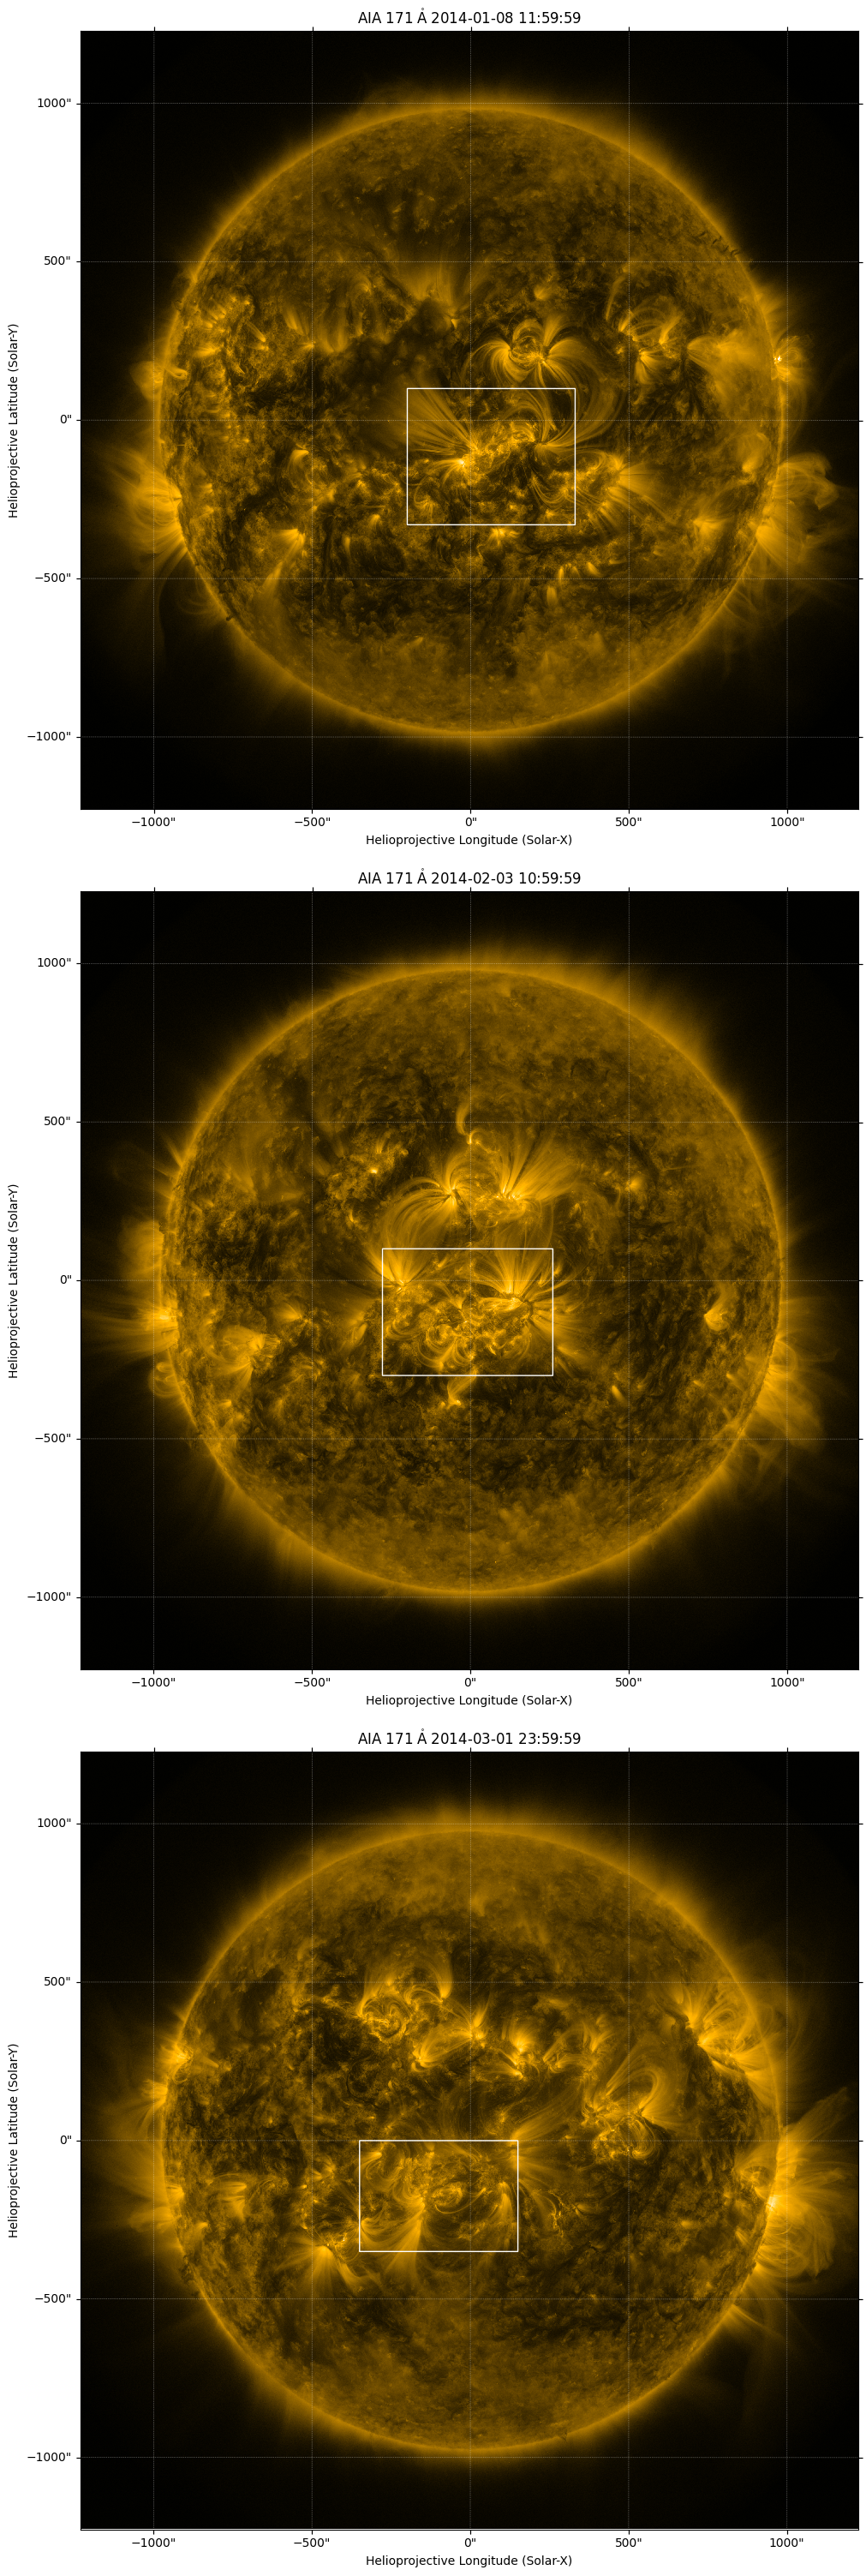

In [19]:
# Plot selected FOV on context images
fig = plt.figure(figsize=(10,30), layout='constrained')
for i,(row,file) in enumerate(zip(mason_ars,aia_files)):
    m = sunpy.map.Map(file)
    ax = fig.add_subplot(len(mason_ars), 1, i+1, projection=m)
    m.plot(axes=ax)
    m.draw_quadrangle(row['bottom left'], top_right=row['top right'], facecolor='k')

Now, let's add the associated EIS file to this table. I manually selected and downloaded these.

In [11]:
mason_ars.add_column(['eis_20140108_095727','eis_20140203_093134','eis_20140302_000659'],
                     name='EIS file')

In [12]:
mason_ars

NOAA AR,Comment,Date start,Date end,Date mid,bottom left,top right,Region ID,EIS file
int64,str80,Time,Time,Time,object,object,int64,str19
11944,Adjusted start time to avoid flare on 2014-01-07 18:00:00,2014-01-08T06:00:00.000,2014-01-08T18:00:00.000,2014-01-08T12:00:00.000,"<SkyCoord (Helioprojective: obstime=2014-01-08T12:00:00.000, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2014-01-08T12:00:00.000, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, AU)\n (0.01553579, -3.85352909, 0.98345929)>): (Tx, Ty) in arcsec\n (-200., -330.)>","<SkyCoord (Helioprojective: obstime=2014-01-08T12:00:00.000, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2014-01-08T12:00:00.000, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, AU)\n (0.01553579, -3.85352909, 0.98345929)>): (Tx, Ty) in arcsec\n (330., 100.)>",1,eis_20140108_095727
11967,Adjusted start time to center interval on EIS raster scan,2014-02-03T05:00:00.000,2014-02-03T17:00:00.000,2014-02-03T11:00:00.000,"<SkyCoord (Helioprojective: obstime=2014-02-03T11:00:00.000, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2014-02-03T11:00:00.000, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, AU)\n (0.01254265, -6.18014202, 0.9858622)>): (Tx, Ty) in arcsec\n (-278., -300.)>","<SkyCoord (Helioprojective: obstime=2014-02-03T11:00:00.000, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2014-02-03T11:00:00.000, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, AU)\n (0.01254265, -6.18014202, 0.9858622)>): (Tx, Ty) in arcsec\n (260., 100.)>",1,eis_20140203_093134
11990,Adjusted start time to avoid eclipse on 2014-03-02 06:00:00,2014-03-01T18:00:00.000,2014-03-02T06:00:00.000,2014-03-02T00:00:00.000,"<SkyCoord (Helioprojective: obstime=2014-03-02T00:00:00.000, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2014-03-02T00:00:00.000, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, AU)\n (-0.01046923, -7.23981545, 0.99093539)>): (Tx, Ty) in arcsec\n (-350., -350.)>","<SkyCoord (Helioprojective: obstime=2014-03-02T00:00:00.000, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2014-03-02T00:00:00.000, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, AU)\n (-0.01046923, -7.23981545, 0.99093539)>): (Tx, Ty) in arcsec\n (150., 0.)>",1,eis_20140302_000659


In [23]:
# Cannot serialize a column of SkyCoord objects when each one is in a different coordinate frame
serializable_table = mason_ars.copy()
serializable_table.replace_column(
    'bottom left',
    u.Quantity([u.Quantity([r['bottom left'].Tx,r['bottom left'].Ty]) for r in serializable_table]),
)
serializable_table.replace_column(
    'top right',
    u.Quantity([u.Quantity([r['top right'].Tx,r['top right'].Ty]) for r in serializable_table]),
)
serializable_table.remove_column('Region ID')
serializable_table.write('../data/tables/mason_ars_region_1.asdf')

In [13]:
selected_line_table.write('../data/tables/selected_eis_lines.asdf')